Installing all requirements for your notebook. Just run the next couple of cells.

In [ ]:
%%capture
!pip install diffusers accelerate
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

To access the stable diffusion model, first connect to huggingface (where the model is stored) and login via your auth token (can be accessed by clicking on the link shown after running the cell)

In [ ]:
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()
from huggingface_hub import notebook_login
from torch import autocast

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### 1. Prompting

Inputing a text prompt to generate an image

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Load the stable diffusion model from huggingface.

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=True)  
pipe = pipe.to("cuda")

Here you can generate new images using texts prompts. Vary the strength and guidance_scale parameters as well as your text input to generate new images.

General help for parameters:

* Prompt should be very descriptive, better use similar words again to make it more clear what you want to put in
* Strength should be value between 0 - 1
* Guidance scale should be value between 1 - 15

Examples how to write good prompts:

* https://pastebin.com/i2EJn6z9
* https://mpost.io/best-100-stable-diffusion-prompts-the-most-beautiful-ai-text-to-image-prompts/
* https://lexica.art/?

  0%|          | 0/51 [00:00<?, ?it/s]

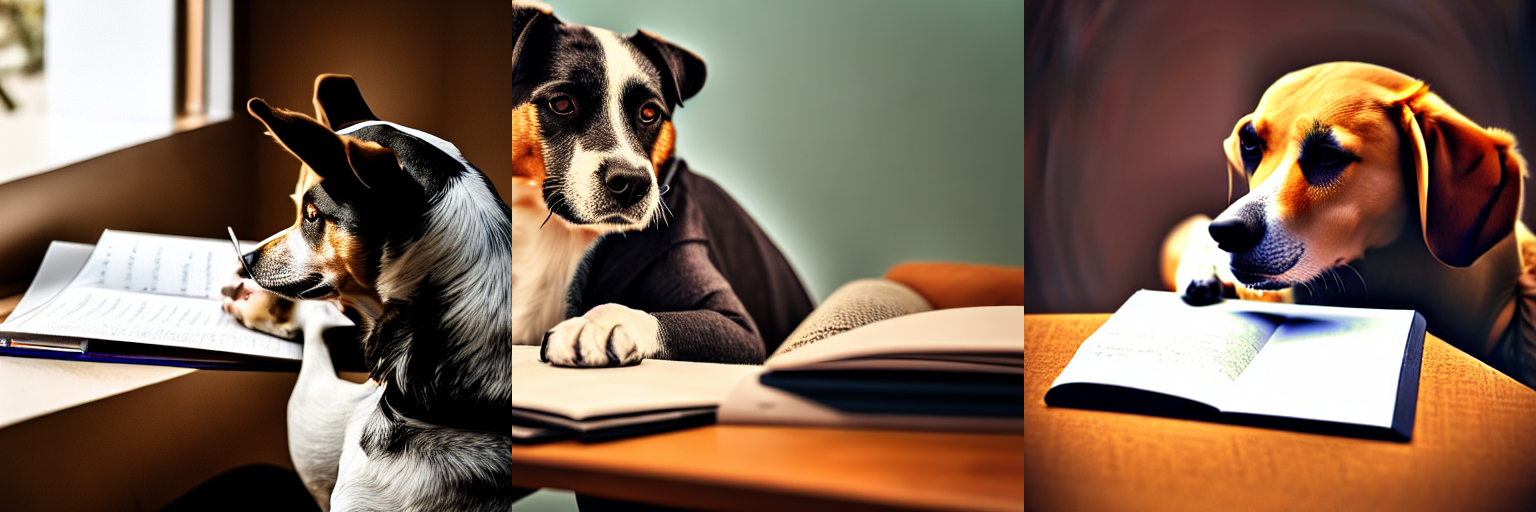

In [ ]:
num_images = 3
prompt = ["a dog writing a novel, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta"] * num_images

with autocast("cuda"): 
  images = pipe(prompt, height=512, width=512, strength=0.7, guidance_scale=15).images

grid = image_grid(images, rows=1, cols=3)
grid

### 2. Image to image

Inputing an image to change it (e.g. fixing a specific part of the image).

In [ ]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

import requests
from io import BytesIO
from PIL import Image

In [ ]:
device = "cuda"
model_path = "/content/drive/MyDrive/Research/stable_diffusion_SelenaGomez_6accum" #"CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    safety_checker=None,
    feature_extractor=None,
    revision="fp16", 
    torch_dtype=torch.float16
)
pipe = pipe.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
url = "https://www.princeton.edu/sites/default/files/styles/half_2x/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=iQEwihUn"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
scale_factor = init_img.size[0]/512
init_img = init_img.resize((int(init_img.size[0]/scale_factor), int(init_img.size[1]/scale_factor)))
init_img

In [ ]:
prompt = "Photo of a dog running"
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
  image = pipe(prompt=prompt, init_image=init_img, strength=0.6, guidance_scale=4, generator=generator).images[0]
image

### 3. Inpainting

Fixing a mask (black area should not be changed) to only modify parts of an image

In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)

In [ ]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

from torch import autocast
def inpaint(p, init_image, mask_image=None, strength=0.75, guidance_scale=7.5, generator=None, num_samples=1, n_iter=1):
    all_images = []
    for _ in range(n_iter):
        with autocast("cuda"):
            images = pipe(
                prompt=[p] * num_samples,
                init_image=init_image,
                mask_image=mask_image,
                strength=strength,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images
        all_images.extend(images)
    return all_images

In [ ]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
init_image = download_image(img_url).resize((512, 512))
init_image

In [ ]:
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [ ]:
prompt = "a cat sitting on a bench"
strength=.75 # should be value between 0 - 1
guidance_scale=7.5 # should be value between 1 - 15
num_samples = 3
n_iter = 1

generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results
all_images = inpaint(prompt, init_image, mask_image, strength=strength, guidance_scale=guidance_scale, generator=generator, num_samples=num_samples, n_iter=n_iter)

In [ ]:
# insert initial image in the list so we can compare side by side
all_images.insert(0, init_image)
image_grid(all_images, n_iter, num_samples + 1)